In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import holoviews as hv
import hvplot.pandas
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.stats as st
import numpy as np
import datetime as dt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency



# Import data
path = "No-Show Data.csv"

noshow_df = pd.read_csv(path)

In [2]:
# Convert 'Booking_Date' and 'Appointment_Date' columns to datetime if not already
noshow_df[['Booking_Date', 'Appointment_Date']] = noshow_df[['Booking_Date', 'Appointment_Date']].apply(pd.to_datetime, errors='coerce')

# Calculate the difference in days, handling NaT values
diff = (noshow_df['Appointment_Date'] - noshow_df['Booking_Date']).dt.days

# Insert 'Days Diff' column at position 13
noshow_df.insert(13, 'Days Diff', diff)
noshow_df

,Patient_ID,Age,Gender,Insurance_Type,Chronic_Disease,Mental_Health_Status,Employment_Status,Education_Level,Transportation_Access,Distance_from_Facility,Area_Type,Booking_Date,Appointment_Date,Days Diff,Appointment_Outcome
0,75763,93.0,Male,Medicare,False,True,Student,Advanced Degree,True,37.785038,Suburban,2023-11-04,2024-08-15,285,Show
1,84945,52.0,Male,Uninsured,False,False,Employed,College,True,NaN,Rural,2023-10-28,2024-07-11,257,No-Show
2,88559,8.0,Male,Medicare,True,NaN,NaN,Advanced Degree,True,27.277654,Rural,2023-02-12,2024-10-26,622,Show
3,72217,5.0,Other,Medicare,False,True,Student,College,True,44.618708,NaN,2023-01-30,2024-01-31,366,Show
4,44071,76.0,Male,Uninsured,True,False,Employed,Advanced Degree,False,12.568497,Urban,2023-11-27,2024-03-03,97,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,16333,48.0,Female,NaN,True,True,Student,NaN,True,26.576418,Urban,2023-11-24,2024-03-16,113,No-Show
49996,11153,5.0,Other,Medicaid,True,True,Student,NaN,False,20.674054,Suburban,2023-11-29,2023-12-05,6,No-Show
49997,15966,92.0,Female,Uninsured,False,True,Student,NaN,True,34.457721,Suburban,2022-11-20,2024-07-27,615,NaN
49998,41988,53.0,Male,Medicaid,False,False,Employed,College,False,21.190068,Suburban,2023-05-02,2023-12-19,231,No-Show


In [3]:
# Only want to inlcude rows that have values for the outcome we are trying to predict
noshow_df = noshow_df.dropna(subset=['Appointment_Outcome'])
noshow_df

,Patient_ID,Age,Gender,Insurance_Type,Chronic_Disease,Mental_Health_Status,Employment_Status,Education_Level,Transportation_Access,Distance_from_Facility,Area_Type,Booking_Date,Appointment_Date,Days Diff,Appointment_Outcome
0,75763,93.0,Male,Medicare,False,True,Student,Advanced Degree,True,37.785038,Suburban,2023-11-04,2024-08-15,285,Show
1,84945,52.0,Male,Uninsured,False,False,Employed,College,True,NaN,Rural,2023-10-28,2024-07-11,257,No-Show
2,88559,8.0,Male,Medicare,True,NaN,NaN,Advanced Degree,True,27.277654,Rural,2023-02-12,2024-10-26,622,Show
3,72217,5.0,Other,Medicare,False,True,Student,College,True,44.618708,NaN,2023-01-30,2024-01-31,366,Show
6,34403,15.0,Female,Medicaid,NaN,False,Unemployed,High School,True,34.033755,Suburban,2023-08-13,2024-07-23,345,Show
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,91361,57.0,Female,Private,True,False,Student,High School,True,28.410940,Suburban,2024-01-26,2024-03-01,35,Show
49995,16333,48.0,Female,NaN,True,True,Student,NaN,True,26.576418,Urban,2023-11-24,2024-03-16,113,No-Show
49996,11153,5.0,Other,Medicaid,True,True,Student,NaN,False,20.674054,Suburban,2023-11-29,2023-12-05,6,No-Show
49998,41988,53.0,Male,Medicaid,False,False,Employed,College,False,21.190068,Suburban,2023-05-02,2023-12-19,231,No-Show


Age

In [4]:
age_df = noshow_df[['Age', 'Appointment_Outcome']]
age_df = age_df.dropna(subset=['Age'])
age_df.isnull().sum()

Age                    0
Appointment_Outcome    0
dtype: int64

In [5]:
outcome_grouped = age_df.groupby('Appointment_Outcome')['Age'].mean()
outcome_grouped

Appointment_Outcome
No-Show    49.773396
Show       49.811338
Name: Age, dtype: float64

In [7]:
outcome1 = age_df[age_df['Appointment_Outcome'] == 'Show']['Age']
outcome2 = age_df[age_df['Appointment_Outcome'] == 'No-Show']['Age']

t_stat, p_value = ttest_ind(outcome1, outcome2, equal_var=False)
print(f'T-statistic: {t_stat}, p-value: {p_value}')

T-statistic: 0.13028408531395658, p-value: 0.8963423186493602


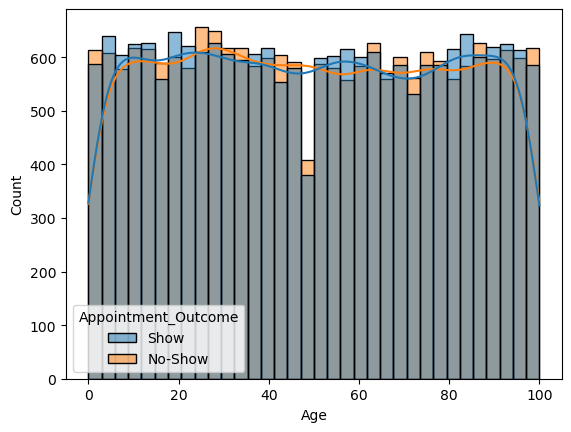

In [8]:
sns.histplot(data=age_df, x='Age', hue='Appointment_Outcome', kde=True)
plt.show()

Gender

In [9]:
gender_df = noshow_df[['Gender', 'Appointment_Outcome']]
gender_df = gender_df.dropna(subset=['Gender'])
gender_df.isnull().sum()

Gender                 0
Appointment_Outcome    0
dtype: int64

In [10]:
outcome_grouped = gender_df.groupby('Appointment_Outcome')['Gender'].value_counts()
outcome_grouped

Appointment_Outcome  Gender
No-Show              Female    6825
                     Male      6720
                     Other     6703
Show                 Female    6831
                     Other     6798
                     Male      6724
Name: count, dtype: int64

In [11]:
# Create a contingency table
contingency_table = pd.crosstab(gender_df['Appointment_Outcome'], gender_df['Gender'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degree of freedom: {dof}')

Chi-square statistic: 0.40075297260414455
P-value: 0.8184225701813225
Degree of freedom: 2


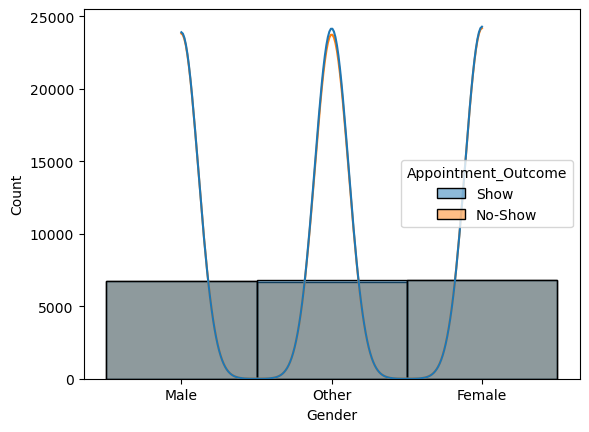

In [12]:
sns.histplot(data=gender_df, x='Gender', hue='Appointment_Outcome', kde=True)
plt.show()

Insurance Type

In [13]:
insurance_df = noshow_df[['Insurance_Type', 'Appointment_Outcome']]
insurance_df = insurance_df.dropna(subset=['Insurance_Type'])
insurance_df.isnull().sum()

Insurance_Type         0
Appointment_Outcome    0
dtype: int64

In [14]:
outcome_grouped = insurance_df.groupby('Appointment_Outcome')['Insurance_Type'].value_counts()
outcome_grouped

Appointment_Outcome  Insurance_Type
No-Show              Uninsured         5155
                     Private           5067
                     Medicare          5018
                     Medicaid          4998
Show                 Medicare          5145
                     Private           5074
                     Uninsured         5056
                     Medicaid          5027
Name: count, dtype: int64

In [15]:
# Create a contingency table
contingency_table = pd.crosstab(insurance_df['Appointment_Outcome'], insurance_df['Insurance_Type'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degree of freedom: {dof}')

Chi-square statistic: 2.5345710598740143
P-value: 0.4690757038574096
Degree of freedom: 3


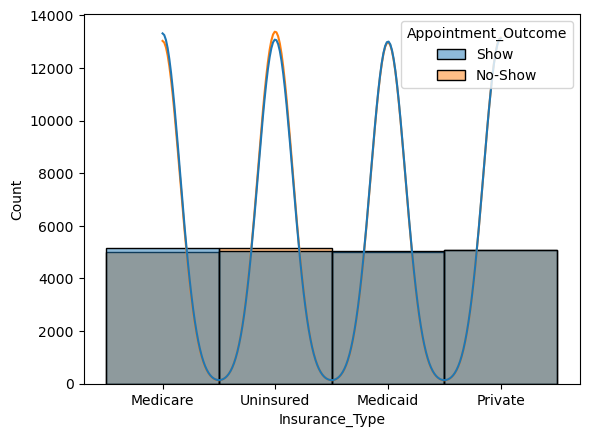

In [16]:
sns.histplot(data=insurance_df, x='Insurance_Type', hue='Appointment_Outcome', kde=True)
plt.show()

Chronic Diseae

In [17]:
disease_df = noshow_df[['Chronic_Disease', 'Appointment_Outcome']]
disease_df = disease_df.dropna(subset=['Chronic_Disease'])
disease_df.isnull().sum()

Chronic_Disease        0
Appointment_Outcome    0
dtype: int64

In [18]:
outcome_grouped = disease_df.groupby('Appointment_Outcome')['Chronic_Disease'].value_counts()
outcome_grouped

Appointment_Outcome  Chronic_Disease
No-Show              False              10293
                     True                9914
Show                 True               10319
                     False              10050
Name: count, dtype: int64

In [19]:
# Create a contingency table
contingency_table = pd.crosstab(disease_df['Appointment_Outcome'], disease_df['Chronic_Disease'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degree of freedom: {dof}')

Chi-square statistic: 10.29902751742617
P-value: 0.0013310033401102964
Degree of freedom: 1


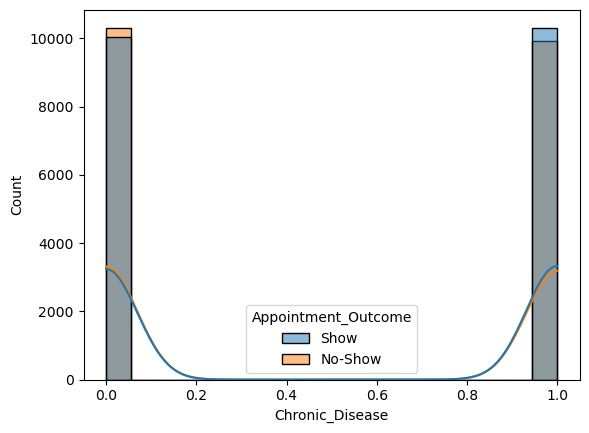

In [20]:
sns.histplot(data=disease_df, x='Chronic_Disease', hue='Appointment_Outcome', kde=True)
plt.show()

Mental Health Status

In [21]:
mental_df = noshow_df[['Mental_Health_Status', 'Appointment_Outcome']]
mental_df = mental_df.dropna(subset=['Mental_Health_Status'])
mental_df.isnull().sum()

Mental_Health_Status    0
Appointment_Outcome     0
dtype: int64

In [22]:
outcome_grouped = mental_df.groupby('Appointment_Outcome')['Mental_Health_Status'].value_counts()
outcome_grouped

Appointment_Outcome  Mental_Health_Status
No-Show              False                   10189
                     True                     9999
Show                 False                   10192
                     True                    10096
Name: count, dtype: int64

In [23]:
# Create a contingency table
contingency_table = pd.crosstab(mental_df['Appointment_Outcome'], mental_df['Mental_Health_Status'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degree of freedom: {dof}')

Chi-square statistic: 0.2123479025214397
P-value: 0.6449333333895646
Degree of freedom: 1


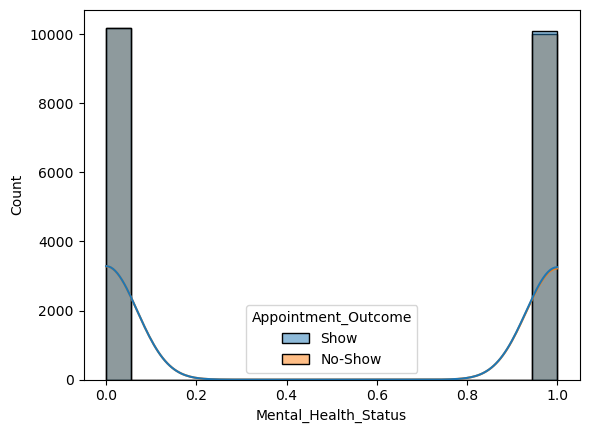

In [24]:
sns.histplot(data=mental_df, x='Mental_Health_Status', hue='Appointment_Outcome', kde=True)
plt.show()

Employment Status

In [25]:
employment_df = noshow_df[['Employment_Status', 'Appointment_Outcome']]
employment_df = employment_df.dropna(subset=['Employment_Status'])
employment_df.isnull().sum()

Employment_Status      0
Appointment_Outcome    0
dtype: int64

In [26]:
outcome_grouped = employment_df.groupby('Appointment_Outcome')['Employment_Status'].value_counts()
outcome_grouped

Appointment_Outcome  Employment_Status
No-Show              Retired              5094
                     Employed             5038
                     Unemployed           5027
                     Student              4994
Show                 Employed             5154
                     Student              5095
                     Retired              5024
                     Unemployed           5004
Name: count, dtype: int64

In [27]:
# Create a contingency table
contingency_table = pd.crosstab(employment_df['Appointment_Outcome'], employment_df['Employment_Status'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degree of freedom: {dof}')

Chi-square statistic: 2.488086080260018
P-value: 0.47744804371792815
Degree of freedom: 3


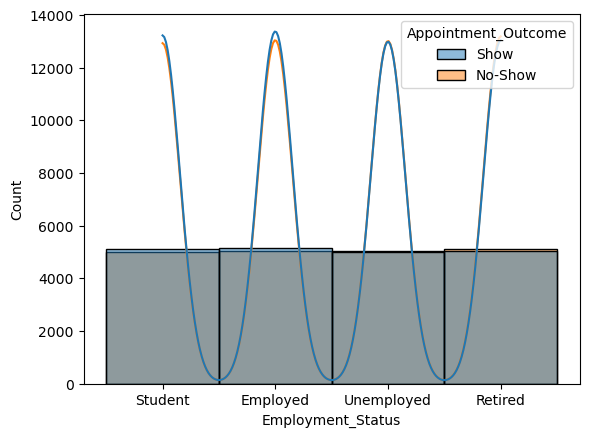

In [28]:
sns.histplot(data=employment_df, x='Employment_Status', hue='Appointment_Outcome', kde=True)
plt.show()

Education Level

In [29]:
education_df = noshow_df[['Education_Level', 'Appointment_Outcome']]
education_df = education_df.dropna(subset=['Education_Level'])
education_df.isnull().sum()

Education_Level        0
Appointment_Outcome    0
dtype: int64

In [30]:
outcome_grouped = education_df.groupby('Appointment_Outcome')['Education_Level'].value_counts()
outcome_grouped

Appointment_Outcome  Education_Level
No-Show              High School        5263
                     Advanced Degree    5071
                     College            4811
Show                 Advanced Degree    5190
                     College            5061
                     High School        5014
Name: count, dtype: int64

In [31]:
# Create a contingency table
contingency_table = pd.crosstab(education_df['Appointment_Outcome'], education_df['Education_Level'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degree of freedom: {dof}')

Chi-square statistic: 13.270781672435085
P-value: 0.001313065451325164
Degree of freedom: 2


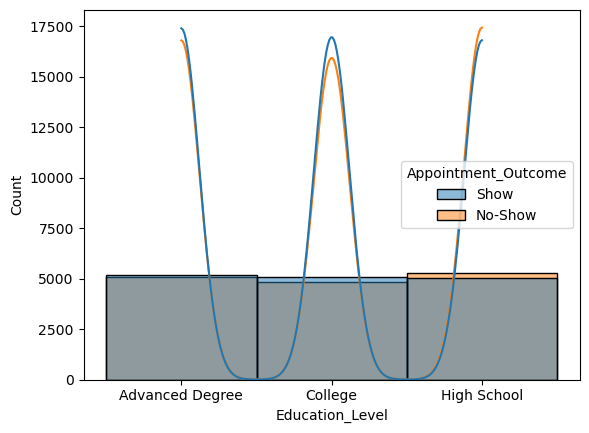

In [32]:
sns.histplot(data=education_df, x='Education_Level', hue='Appointment_Outcome', kde=True)
plt.show()

Transportation Access

In [33]:
transport_df = noshow_df[['Transportation_Access', 'Appointment_Outcome']]
transport_df = transport_df.dropna(subset=['Transportation_Access'])
transport_df.isnull().sum()

Transportation_Access    0
Appointment_Outcome      0
dtype: int64

In [34]:
outcome_grouped = transport_df.groupby('Appointment_Outcome')['Transportation_Access'].value_counts()
outcome_grouped

Appointment_Outcome  Transportation_Access
No-Show              False                    10111
                     True                     10074
Show                 False                    10197
                     True                     10138
Name: count, dtype: int64

In [35]:
# Create a contingency table
contingency_table = pd.crosstab(transport_df['Appointment_Outcome'], transport_df['Transportation_Access'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degree of freedom: {dof}')

Chi-square statistic: 0.009524149737754978
P-value: 0.9222564754966903
Degree of freedom: 1


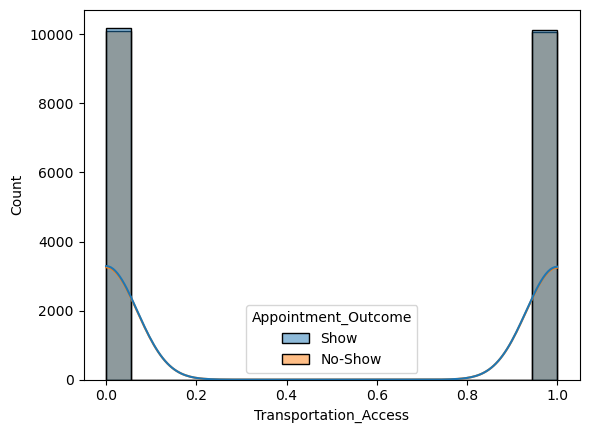

In [36]:
sns.histplot(data=transport_df, x='Transportation_Access', hue='Appointment_Outcome', kde=True)
plt.show()

Distance From Facility

In [37]:
distance_df = noshow_df[['Distance_from_Facility', 'Appointment_Outcome']]
distance_df = distance_df.dropna(subset=['Distance_from_Facility'])
distance_df.isnull().sum()

Distance_from_Facility    0
Appointment_Outcome       0
dtype: int64

In [38]:
outcome_grouped = distance_df.groupby('Appointment_Outcome')['Distance_from_Facility'].mean()
outcome_grouped

Appointment_Outcome
No-Show    25.044503
Show       25.074885
Name: Distance_from_Facility, dtype: float64

In [39]:
outcome1 = distance_df[distance_df['Appointment_Outcome'] == 'Show']['Distance_from_Facility']
outcome2 = distance_df[distance_df['Appointment_Outcome'] == 'No-Show']['Distance_from_Facility']

t_stat, p_value = ttest_ind(outcome1, outcome2, equal_var=False)
print(f'T-statistic: {t_stat}, p-value: {p_value}')

T-statistic: 0.2120925617413726, p-value: 0.832035890096307


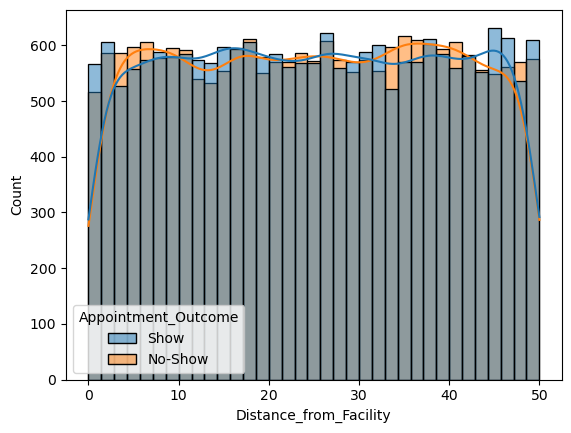

In [40]:
sns.histplot(data=distance_df, x='Distance_from_Facility', hue='Appointment_Outcome', kde=True)
plt.show()

Area Type

In [41]:
area_df = noshow_df[['Area_Type', 'Appointment_Outcome']]
area_df = area_df.dropna(subset=['Area_Type'])
area_df.isnull().sum()

Area_Type              0
Appointment_Outcome    0
dtype: int64

In [42]:
outcome_grouped = area_df.groupby('Appointment_Outcome')['Area_Type'].value_counts()
outcome_grouped

Appointment_Outcome  Area_Type
No-Show              Urban        6760
                     Suburban     6755
                     Rural        6742
Show                 Urban        6826
                     Rural        6763
                     Suburban     6720
Name: count, dtype: int64

In [43]:
# Create a contingency table
contingency_table = pd.crosstab(area_df['Appointment_Outcome'], area_df['Area_Type'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degree of freedom: {dof}')

Chi-square statistic: 0.3775316493874342
P-value: 0.8279803765523565
Degree of freedom: 2


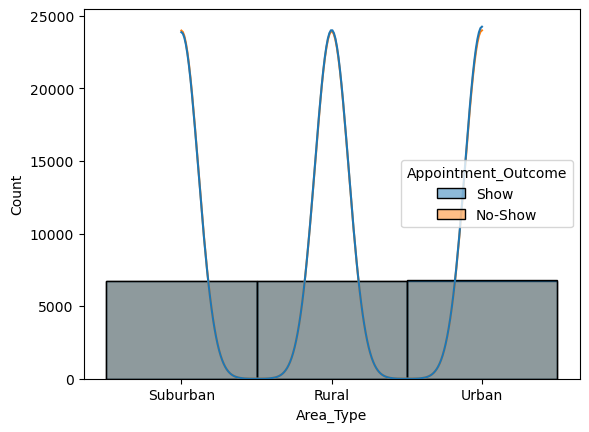

In [44]:
sns.histplot(data=area_df, x='Area_Type', hue='Appointment_Outcome', kde=True)
plt.show()

Booking Date

In [45]:
booking_df = noshow_df[['Booking_Date', 'Appointment_Outcome']]
booking_df = booking_df.dropna(subset=['Booking_Date'])
booking_df.isnull().sum()

Booking_Date           0
Appointment_Outcome    0
dtype: int64

In [46]:
outcome_grouped = booking_df.groupby('Appointment_Outcome')['Booking_Date'].value_counts()
outcome_grouped

Appointment_Outcome  Booking_Date
No-Show              2023-02-25      60
                     2023-01-12      60
                     2023-08-09      59
                     2023-10-04      57
                     2023-09-02      57
                                     ..
Show                 2024-09-09       1
                     2024-09-29       1
                     2024-10-04       1
                     2024-10-05       1
                     2024-11-11       1
Name: count, Length: 1435, dtype: int64

In [47]:
# Create a contingency table
contingency_table = pd.crosstab(booking_df['Appointment_Outcome'], booking_df['Booking_Date'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degree of freedom: {dof}')

Chi-square statistic: 712.052835101832
P-value: 0.6071101104756472
Degree of freedom: 723


In [53]:
booking_df['Booking_Date'] = pd.to_datetime(booking_df['Booking_Date'])

# Calculate the number of days since the earliest booking date
booking_df['Relative_Booking_Date'] = (booking_df['Booking_Date'] - booking_df['Booking_Date'].min()).dt.days

outcome1 = booking_df[booking_df['Appointment_Outcome'] == 'Show']['Relative_Booking_Date']
outcome2 = booking_df[booking_df['Appointment_Outcome'] == 'No-Show']['Relative_Booking_Date']

t_stat, p_value = ttest_ind(outcome1, outcome2, equal_var=False)
print(f'T-statistic: {t_stat}, p-value: {p_value}')

T-statistic: -0.3538460300225601, p-value: 0.7234559316477589


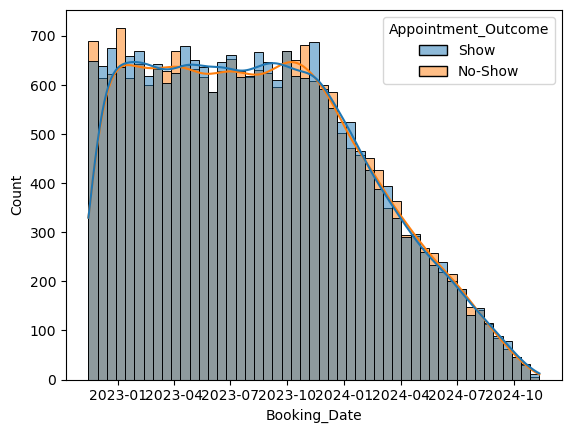

In [49]:
sns.histplot(data=booking_df, x='Booking_Date', hue='Appointment_Outcome', kde=True)
plt.show()

Appointment Date

In [50]:
appointment_df = noshow_df[['Appointment_Date', 'Appointment_Outcome']]
appointment_df = appointment_df.dropna(subset=['Appointment_Date'])
appointment_df.isnull().sum()


Appointment_Date       0
Appointment_Outcome    0
dtype: int64

In [51]:
outcome_grouped = appointment_df.groupby('Appointment_Outcome')['Appointment_Date'].value_counts()
outcome_grouped

Appointment_Outcome  Appointment_Date
No-Show              2024-11-10          84
                     2024-10-24          80
                     2023-12-31          80
                     2024-06-20          79
                     2024-04-21          78
                                         ..
Show                 2024-05-25          45
                     2024-06-30          44
                     2024-07-03          44
                     2024-07-09          44
                     2024-01-05          43
Name: count, Length: 730, dtype: int64

In [52]:
# Create a contingency table
contingency_table = pd.crosstab(appointment_df['Appointment_Outcome'], appointment_df['Appointment_Date'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degree of freedom: {dof}')

Chi-square statistic: 331.1435970753461
P-value: 0.8909386780882076
Degree of freedom: 364


In [54]:
appointment_df['Appointment_Date'] = pd.to_datetime(appointment_df['Appointment_Date'])

# Calculate the number of days since the earliest booking date
appointment_df['Relative_Appointment_Date'] = (appointment_df['Appointment_Date'] - appointment_df['Appointment_Date'].min()).dt.days

outcome1 = appointment_df[appointment_df['Appointment_Outcome'] == 'Show']['Relative_Appointment_Date']
outcome2 = appointment_df[appointment_df['Appointment_Outcome'] == 'No-Show']['Relative_Appointment_Date']

t_stat, p_value = ttest_ind(outcome1, outcome2, equal_var=False)
print(f'T-statistic: {t_stat}, p-value: {p_value}')

T-statistic: -1.8966266994144225, p-value: 0.05788361701071828


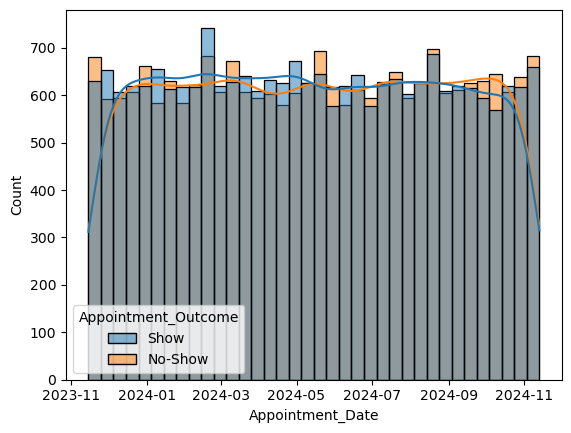

In [55]:
sns.histplot(data=appointment_df, x='Appointment_Date', hue='Appointment_Outcome', kde=True)
plt.show()

Days Between Booking Date and Appointment Date

In [56]:
days_df = noshow_df[['Days Diff', 'Appointment_Outcome']]
days_df = days_df.dropna(subset=['Days Diff'])
days_df.isnull().sum()

Days Diff              0
Appointment_Outcome    0
dtype: int64

In [57]:
outcome_grouped = days_df.groupby('Appointment_Outcome')['Days Diff'].value_counts()
outcome_grouped

Appointment_Outcome  Days Diff
No-Show              20           61
                     106          60
                     272          60
                     273          59
                     79           58
                                  ..
Show                 701           1
                     696           1
                     694           1
                     674           1
                     727           1
Name: count, Length: 1437, dtype: int64

In [58]:
outcome1 = days_df[days_df['Appointment_Outcome'] == 'Show']['Days Diff']
outcome2 = days_df[days_df['Appointment_Outcome'] == 'No-Show']['Days Diff']

t_stat, p_value = ttest_ind(outcome1, outcome2, equal_var=False)
print(f'T-statistic: {t_stat}, p-value: {p_value}')

T-statistic: -0.82263154674867, p-value: 0.41072190854621937


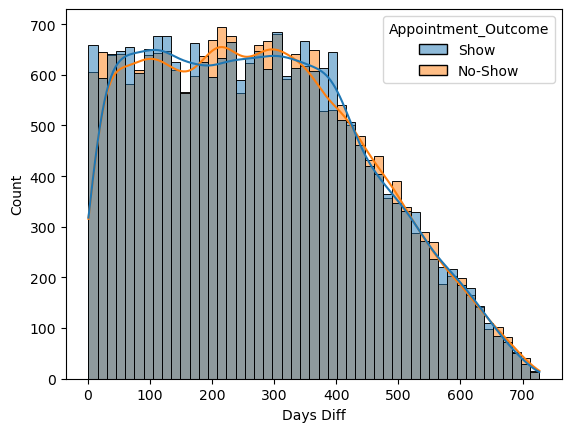

In [60]:
sns.histplot(data=days_df, x='Days Diff', hue='Appointment_Outcome', kde=True)
plt.show()

In [64]:
noshow_df.to_csv('significant_df.csv', index=False)